---
title: "The Correlation Matrix"
bibliography: "../../blog.bib"
author: "Peter Amerkhanian"
date: "2024-3-25"
draft: true
categories: ['Python', 'Linear Algebra']
format:
  html:
    toc: true
    toc-depth: 3
    code-fold: false
    code-tools: true
editor: 
  markdown: 
    wrap: 72
---

In [1]:
#| code-fold: true
import numpy as np
import pandas as pd
import ucimlrepo
import sympy as sp
import matplotlib.pyplot as plt

The following is largely based on exercises in [@cohen_practical_2022], an excellent overview of applied, numerical linear algebra in python. This exercise is an overview of how to compute the covariance matrix of a dataset, and contains enough fundamental linear algebra topics -- matrix multiplication, matrices as functions, etc. -- that I wanted to commit it to a blog for my future reference.  

This will be a long post with almost no computational value. Almost all of the methods and objects I cover come up in analytical, not numerical, linear algebra. Either way, I think that it's useful to go through these to get some understanding of how to combine matrix operations to get interesting output.

# Question and Data
The exercise dataset used in the textbook is ["Communities and Crime," from the UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/dataset/183/communities+and+crime), which includes data on  

> Communities within the United States. The data combines socio-economic data from the 1990 US Census, law enforcement data from the 1990 US LEMAS survey, and crime data from the 1995 FBI UCR.  
>

In the exercise, we are tasked with creating a covariance matrix of the data.

In [2]:
#| code-fold: true
# Fetch the dataset 
communities_and_crime: ucimlrepo.dotdict = ucimlrepo.fetch_ucirepo(id=183) 
df: pd.DataFrame = pd.concat([communities_and_crime.data.features,
                              communities_and_crime.data.features], axis=1)
# Isolate numerical features and clear duplicate columns
df_num: pd.DataFrame = df.copy().select_dtypes(include='number')
df_num = df_num.loc[:,~df_num.columns.duplicated()]
df_num = df_num.iloc[:, 2:]

To make the operations as clear as possible, I'm going to overview the process using only the first five rows before computing the full covariance matrix.

In [3]:
example = df_num.head()
example

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.0,0.12,0.42,0.50,0.51,0.64,0.12,0.26,0.20,0.32
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.0,0.21,0.50,0.34,0.60,0.52,0.02,0.12,0.45,0.00
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.0,0.14,0.49,0.54,0.67,0.56,0.01,0.21,0.02,0.00
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.0,0.19,0.30,0.73,0.64,0.65,0.02,0.39,0.28,0.00
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.0,0.11,0.72,0.64,0.61,0.53,0.04,0.09,0.02,0.00


## Bivariate Covariance via Summation
Say we have two columns, `householdsize` and `population`, and we'd like to know to what degree they are associated.

In [63]:
x = example['population']
y = example['householdsize']
example[['population', 'householdsize']]

,population,householdsize
0,0.19,0.33
1,0.00,0.16
2,0.00,0.42
3,0.04,0.77
4,0.01,0.55


I can compute their covariance statistic via the following equation, where $x$ is, say `population`, and $y$ is `householdsize`

$$
c_{x, y} = (n-1)^{-1} \sum_{i=1} ^n (x_i - \bar{x})(y_i - \bar{y})
$${#eq-one}
[@cohen_practical_2022, chapter 7]

I create a function as follows to flexibly compute this formula for two arrays of data.

In [64]:
def bivariate_cov(x: np.array, y: np.array) -> float:
    x_bar: float = x.mean()
    y_bar: float = y.mean()
    n = len(x)
    summation = 0
    for i in range(n):
        summation += (x.loc[i] - x_bar) * (y.loc[i] - y_bar)
    return summation / (n-1)

For these two variables, we find the covariance as follows:

In [65]:
print("cov(x, y):", bivariate_cov(x, y))

cov(x, y): -0.0020099999999999996


I'll check my answer with a built in function, `numpy.cov()`:

In [66]:
np.cov(x, y)

array([[ 0.00657, -0.00201],
       [-0.00201,  0.05293]])

This is clearly different! Rather than a scalar, this function returned a matrix. However, the upper and lower triangles of the matrix are the same as the covariance value we computed. Indeed, what numpy returned for covariance is the following matrix:
$$
\left[
\begin{matrix}
    var(x) & cov(x, y) \\
    cov(y, x) & var(y) \\
\end{matrix}
\right]
$$

We can compute the variances of $x$ and $y$ to confirm this (note that variance is, in a sense, a vector's covariance with itself) 

In [67]:
print("var(x):", bivariate_cov(x, x))
print("var(y):", bivariate_cov(y, y))

var(x): 0.006570000000000002
var(y): 0.05293000000000001


## The Vector Formula for Bivariate Covariance
To get our output to match numpy's we'll start by generalizing the covariance equation to input vectors. Recall the no linear algebra, summation equation, (@eq-one):

$$
\begin{align*}
c_{x, y} &= (n-1)^{-1} \sum_{i=1} ^n (x_i - \bar{x})(y_i - \bar{y}) \\
\end{align*}  
$$  

To convert this into an equation that uses vectors, we'll note that the $\sum_{i=1}^n(\cdots)_i(\cdots)_i$ term above corresponds to a "dot product" in linear algebra. We write this out as follows:
$$
\begin{align*}
c_{x, y} &= (n-1)^{-1}(\mathbf {x}_{n \times 1} - \bar{\mathbf {x}})^\intercal (\mathbf {y}_{n \times 1} - \bar{\mathbf {y}}) \\
\end{align*}  
$$

[@cohen_practical_2022, chapter 7]  

Note the following notational conventions:  

- the boldface x, $\mathbf {x}_{n \times 1}$ refers to a vector with all the elements $x_i$, $i \in [1,2, \cdots, n]$
- $\bar{\mathbf {x}}$ and $\bar{x}$ are equivalent -- both represent the mean of the vector.
- $^\intercal$ represents the transpose -- we'll get to what it means and why it's important in the section on the matrix formulation, but you can ignore it for now.

To compute this formula, I'll denote the vectors and their means below:

In [83]:
print("x:", x.values, "mean(x)=", x.mean())
print("y:", y.values,  "mean(y)=", y.mean())
print("n = ", len(x))

x: [0.19 0.   0.   0.04 0.01] mean(x)= 0.048
y: [0.33 0.16 0.42 0.77 0.55] mean(y)= 0.446
n =  5


And we can now plug everything into that vector formula for covariance:

$$
\begin{align*}
c_{x, y} &= (n-1)^{-1}(\mathbf {x}_{n \times 1} - \bar{\mathbf {x}})^\intercal (\mathbf {y}_{n \times 1} - \bar{\mathbf {y}}) \\
c_{x,y} &= \frac{1}{4} (\left[\begin{matrix}0.19\\0\\0\\0.04\\0.01\end{matrix}\right] - 0.048)^\intercal (\left[\begin{matrix}0.33\\0.16\\0.42\\0.77\\0.55\end{matrix}\right] - 0.446) \\
c_{x,y} &= \frac{1}{4} (\left[\begin{matrix}0.142\\-0.048\\-0.048\\-0.008\\-0.038\end{matrix}\right]^\intercal \left[\begin{matrix}-0.116\\-0.286\\-0.026\\0.324\\0.104\end{matrix}\right]) \\
&= \frac{1}{4} ((0.142) (-0.116) + (-0.048) (-0.286) \\
&\quad \quad + (-0.048) (-0.026) + (-0.008) (0.324) \\
&\quad \quad + (-0.038) (0.104) )  \\
&\approx \frac{1}{4} (-0.00804) \\
&\approx -0.00201
\end{align*}
$$

In python we can confirm our result, where `@` computes the dot product in python's `numpy` library:

In [84]:
x_bar: float = x.mean()
y_bar: float = y.mean()
n = len(x)
((x - x_bar).T @ (y - y_bar)) / (n - 1)

-0.0020099999999999996

and we quickly confirm that this outputs the same value as the summation equation we implemented earlier

In [100]:
assert  bivariate_cov(x, y) == ((x - x_bar).T @ (y - y_bar)) / (n - 1)

## The Matrix Formulation
In my view, the vector formulation is not particularly useful, so we will quickly move on to the matrix formulation. This formula can take in an arbitrary number of variables and compute the covariance between each of them, and it's going to give us the same output as `np.cov()`. 

Before we get to the equation, we'll start by defining a matrix, $X$, made up of the vectors $\mathbf{x}$ and $\mathbf{y}$:  
$$
X_{n \times 2} = 
\left[
\begin{matrix}
\vert & \vert \\
    \mathbf{x}   & \mathbf{y}   \\
    \vert & \vert
\end{matrix}
\right]_{n \times 2} = \left[
\begin{matrix}
    x_1   & y_1   \\
    x_2   & y_2   \\
    \vdots   & \vdots   \\
    x_n   & y_n   \\
\end{matrix}
\right]_{n \times 2}
$$  

This is really just our full dataset:

In [85]:
X = example[['population', 'householdsize']]
X

,population,householdsize
0,0.19,0.33
1,0.00,0.16
2,0.00,0.42
3,0.04,0.77
4,0.01,0.55


Lets now consider what objects were necessary in the "no linear algebra", summation equation, (@eq-one):  
$$
c_{x, y} = (n-1)^{-1} \sum_{i=1} ^n (x_i - \bar{x})(y_i - \bar{y})
$$  

The key components:  

1. $(n-1)^{-1}$, a straightforward scalar value.
2. $x_i - \bar{x}$ and $y_i - \bar{y}$. we have already seen that these are vectors denoting the deviations of each element in a vector, e.g. $\mathbf{x}$ from the mean, $\bar{x}$
3. $\sum_{i=1} ^n (\cdots)_i(\cdots)_i$. As we stated earlier this is a "dot product."

Let's think about how we can define component 2., $x_i - \bar{x}$ and $y_i - \bar{y}$, in terms of matrices.  

We want to subtract x elements from the mean of x, and y elements from the mean of y. In the vector setting above, we set this up as the difference between a vector and its scalar mean: 

$$
\left[
\begin{matrix}
    x_1  \\
    x_2   \\
    \vdots   \\
    x_n 
\end{matrix}
\right]_{n \times 1} - \bar{\mathbf{x}} = \left[
\begin{matrix}
x_1 - \bar{\mathbf{x}}   \\
    x_2 - \bar{\mathbf{x}}    \\
    \vdots   \\
    x_n - \bar{\mathbf{x}}     \\
\end{matrix}
\right]_{n \times 1}
$$


We now move to a matrix formulation of this operation so that we can operate on more than one column of data at once. Matrix subtraction is thankfully straightforward,  
  
> You add [or subtract] two matrices by adding their corresponding elements. [...] Matrix addition [and subtraction] is defined only between two
matrices of the same size
>
> -- [@cohen_practical_2022, chapter 5]

Given that, we can set $x_i - \bar{x}$ and $y_i - \bar{y}$ up in a matrix formulation as follows:  

$$ 
x_i - \bar{x} \text{ and } y_i - \bar{y} \rightarrow 
\left[
\begin{matrix}
    x_1   & y_1   \\
    x_2   & y_2   \\
    \vdots   & \vdots   \\
    x_n   & y_n   \\
\end{matrix}
\right]_{n \times 2} - 
\left[
\begin{matrix}
    \bar{\mathbf{x}}   & \bar{\mathbf{y}}   \\
    \bar{\mathbf{x}}   & \bar{\mathbf{y}}   \\
    \vdots   & \vdots   \\
    \bar{\mathbf{x}}   & \bar{\mathbf{y}}   \\
\end{matrix}
\right]_{n \times 2} = 
\left[
\begin{matrix}
x_1 - \bar{\mathbf{x}}   & y_1 - \bar{\mathbf{y}}   \\
    x_2 - \bar{\mathbf{x}}   & y_2 - \bar{\mathbf{y}}   \\
    \vdots   & \vdots   \\
    x_n - \bar{\mathbf{x}}   & y_n - \bar{\mathbf{y}}   \\
\end{matrix}
\right]_{n \times 2}
$$

But how do we produce the $n \times 2$ matrix of column means that this equation requires?  
$$
\left[
\begin{matrix}
    \bar{\mathbf{x}}   & \bar{\mathbf{y}}   \\
    \bar{\mathbf{x}}   & \bar{\mathbf{y}}   \\
    \vdots   & \vdots   \\
    \bar{\mathbf{x}}   & \bar{\mathbf{y}}   \\
\end{matrix}
\right]_{n \times 2}
$${#eq-mat-means}

We can of course devise some code that will give us that matrix, but thinking about how to produce this analytically, with linear algebra, yields some useful insights, so lets try...  

Given that these means are functions of the elements of $\mathbf{x}$ and $\mathbf{y}$ respectively, we are going to try to create a function that takes in the matrix $X$ and outputs the matrix of means above. What's interesting is that with linear algebra, we can conceive of *functions as matrices*, so really we are looking for a matrix we can multiply with $X$ to produce (@eq-mat-means). This is going to be very notationally useful when we write the matrix formulation for covariance, but we will build up to that by first producing (@eq-mat-means).

### The mean as a matrix transformation
To build that function/matrix, lets start by considering a standard definition of the average and translate it into a function that takes in a vector, multiplies it with another vector, and outputs the average of the input vector. The simple summation formulation for the mean is as follows:  
$$
\bar{x} = \frac{1}{n}\sum_{i=1}^n x_i = \sum_{i=1}^n \frac{1}{n}x_i
$$
The summation, $\sum_{i=1}^n \frac{1}{n}x_i$, maps directly to a simple dot product:  
$$
\begin{align*}
\bar{x} &= \sum_{i=1}^n \frac{1}{n}x_i \\
&= \frac{1}{n}x_1 + \frac{1}{n}x_2 + \cdots \frac{1}{n}x_n \\
&= \left[\begin{matrix}\frac{1}{n} & \frac{1}{n} & \cdots & \frac{1}{n}\end{matrix}\right]_{1 \times n} \left[\begin{matrix}x_1\\x_2\\\vdots\\x_n\end{matrix}\right]_{n \times 1}
\end{align*}
$$
This is interesting (really), because it looks like if we multiply $\left[\begin{matrix}\frac{1}{n} & \frac{1}{n} & \cdots & \frac{1}{n}\end{matrix}\right]_{1 \times n}$ by any $n \times 1$ vector, we get the mean. So it seems like the following is a function that takes in a vector, multiplies it with another vector, and outputs the average of the input vector:
$$
\bar{x} = f(\mathbf{x}_{n \times 1}) = \left[\begin{matrix}\frac{1}{n} & \frac{1}{n} & \cdots & \frac{1}{n}\end{matrix}\right]_{1 \times n} \mathbf{x}_{n \times 1}
$${#eq-simple-mean}
 
Lets confirm this behavior with code:

In [86]:
print("n =", len(x))
print("[1/n, 1/n, ... 1/n] = ", 1/len(x) * np.ones(len(x)).T)

n = 5
[1/n, 1/n, ... 1/n] =  [0.2 0.2 0.2 0.2 0.2]


In [89]:
print(
    "f(x) = ", 1/len(x) * np.ones(len(x)).T @ x
    )
print("mean = ", x.mean())
print("^ these are equal")

f(x) =  0.04800000000000001
mean =  0.048
^ these are equal


Now that we've confirmed that the function works, lets formalize it and make its notation clear. Consider a vector of 1s, $\mathbf{1}$:  
$$
\mathbf{1}_{n \times 1} = \left[\begin{matrix}1\\1\\\vdots\\1\end{matrix}\right]_{n \times 1} \\
$$
If we mutliply that by $1/n$, we get something like the vector that defines our function:  
$$
n^{-1}\mathbf{1}_{n \times 1} = \left[\begin{matrix}\frac{1}{n} \\ \frac{1}{n} \\ \vdots \\ \frac{1}{n}\end{matrix}\right]_{n \times 1}
$$  
The only problem with this is that its vertical rather than horizontal, so we'll use the transpose to get what we previously saw in our function, (@eq-simple-mean):
$$
n^{-1}\mathbf{1}_{n \times 1}^\intercal = \left[\begin{matrix}\frac{1}{n} & \frac{1}{n} & \cdots & \frac{1}{n}\end{matrix}\right]_{1 \times n}
$$  

With that notation, we'll now define the function in clear notation:
$$
\begin{align*}
f(\mathbf{x}_{n \times 1}) &= n^{-1}\mathbf{1}_{n \times 1}^\intercal \mathbf{x}_{n \times 1}
\end{align*}
$$

So the average can be conceived of as the matrix transformation that transforms a $n \times 1$ vector into its scalar mean.
$$
T: \mathbb{R}^n \rightarrow \mathbb{R}^1 \quad \text{defined by} \quad T(\mathbf{x}_{n \times 1}) = n^{-1}\mathbf{1}_{n \times 1}^\intercal \mathbf{x}_{n \times 1}
$$  

Looks weird and potentially useless, but this sort of thinking becomes more useful when we move on to finding a matrix transformation that gets us the element-wise deviations from the mean,  (@eq-mat-means).

### Deviation from the mean as a matrix transformation

$f(\mathbf{x}_{n \times 1}) = n^{-1}\mathbf{1}_{n \times 1}^\intercal \mathbf{x}_{n \times 1}$ yields a scalar, $\bar{x}$, but I want the matrix:
$$
\left[
\begin{matrix}
    \bar{\mathbf{x}}   & \bar{\mathbf{y}}   \\
    \bar{\mathbf{x}}   & \bar{\mathbf{y}}   \\
    \vdots   & \vdots   \\
    \bar{\mathbf{x}}   & \bar{\mathbf{y}}   \\
\end{matrix}
\right]_{n \times 2}
$$
To move towards that output, lets start with getting a function that can output the first column:
$$
\left[
\begin{matrix}
    \bar{\mathbf{x}}   \\
    \bar{\mathbf{x}} \\
    \vdots    \\
    \bar{\mathbf{x}}    \\
\end{matrix}
\right]_{n \times 1}
$$

#### An aside about matrix multiplication rules
To get this specified output, an $n \times 1$ vector, lets cover some basics of matrix multiplication.  
In matrix multiplication, the following properties hold with regards to dimensions of the input and output:  

1. Operations are only valid if the column dimension of the left input matrix matches the row dimension of the right input matrix.
2. The output has the row dimension of the left matrix and the column dimension of the right matrix.

-- [@cohen_practical_2022, chapter 5]  

For example, in all of our previous vector $\times$ vector operations, our dimensionality was as follows:  
$$
\begin{align*}
(1 \times \fbox{n})(\fbox{n} \times 1) \quad& (n = n) \rightarrow \text{Operation is valid} \\
(\fbox{1} \times n)(n \times \fbox{1}) \quad& (1 \times 1) \rightarrow \text{Output is scalar} 
\end{align*}
$$
(Sometimes we had to transpose one of the vectors for this to be the case).  

If we want to produce an $n \times 1$ matrix from a multiplication operation involving an $n \times 1$ input, we would need a matrix with the following, underlined dimensionality:  
$$
\underline{(n \times n)} (n \times 1) \rightarrow \text{Valid operation with output: } (n \times 1)
$$
Upon some reflection, the $n \times n$ matrix must be the matrix where every element is $1/n$. The following operation gives us the desired column vector with all elements set as the original column mean:
$$
\left[
\begin{matrix}
    \frac{1}{n}   & \frac{1}{n}   & \cdots & \frac{1}{n}\\
    \frac{1}{n}   & \frac{1}{n}   & \cdots & \frac{1}{n}\\
    \vdots   & \vdots   & \cdots & \frac{1}{n}\\
    \frac{1}{n}   & \frac{1}{n}   & \cdots & \frac{1}{n}
\end{matrix}
\right]_{n \times n} \left[\begin{matrix}x_1\\x_2\\\vdots\\x_n\end{matrix}\right]_{n \times 1} = 
\left[
\begin{matrix}
    \sum_{i=1}^n \frac{x}{n}  \\
    \sum_{i=1}^n \frac{x}{n} \\
    \vdots  \\
    \sum_{i=1}^n \frac{x}{n}  \\
\end{matrix}
\right]_{n \times 1} = \left[
\begin{matrix}
    \bar{\mathbf{x}}   \\
    \bar{\mathbf{x}} \\
    \vdots    \\
    \bar{\mathbf{x}}    \\
\end{matrix}
\right]_{n \times 1}
$$

#### Notation of the transformation
Thus that matrix of $1/n$ values is the matrix transformation that we will need in our covariance matrix equation. We'll now formalize the construction of that matrix so that we can write it in an equation, and show that it generalizes to multiple input columns.  

We can construct a square matrix of 1s by multiplying the 1s vector with its transpose, $(n \times 1)(1 \times n) \rightarrow (n \times n)$:
$$
\begin{align*}
\mathbf{1}_{n \times 1} \mathbf{1}_{n \times 1}^\intercal &= \left[\begin{matrix}1\\1\\\vdots\\1\end{matrix}\right]_{n \times 1} \left[\begin{matrix}1 & 1 & \cdots & 1\end{matrix}\right]_{1 \times n} = \left[
\begin{matrix}
    1   & 1   & \cdots & 1\\
    1   & 1   & \cdots & 1\\
    \vdots   & \vdots   & \cdots & 1\\
    1   & 1   & \cdots & 1
\end{matrix}
\right]_{n \times n}
\end{align*}
$$
This is a very useful matrix given that we want to define a matrix transformation where every element of the matrix is $1/n$. scalar matrix multiplication is intuitive and comes out as follows:

$$
\begin{align*}
n^{-1} \mathbf{1}_{n \times 1} \mathbf{1}_{n \times 1}^\intercal &= n^{-1}\left[
\begin{matrix}
    1   & 1   & \cdots & 1\\
    1   & 1   & \cdots & 1\\
    \vdots   & \vdots   & \cdots & 1\\
    1   & 1   & \cdots & 1
\end{matrix}
\right]_{n \times n} = \left[
\begin{matrix}
    \frac{1}{n}   & \frac{1}{n}   & \cdots & \frac{1}{n}\\
    \frac{1}{n}   & \frac{1}{n}   & \cdots & \frac{1}{n}\\
    \vdots   & \vdots   & \cdots & \frac{1}{n}\\
    \frac{1}{n}   & \frac{1}{n}   & \cdots & \frac{1}{n}
\end{matrix}
\right]_{n \times n}
\end{align*}
$$  

Thus the transformation that creates the "matrix of means," (@eq-mat-means) is $n^{-1} \mathbf{1}_{n \times 1} \mathbf{1}_{n \times 1}^\intercal$ applied to an input matrix, $X$:  
$$
\begin{align*}
 n^{-1} \mathbf{1}_{n \times 1} \mathbf{1}_{n \times 1}^\intercal X_{n \times 2} &= \left[
\begin{matrix}
    \frac{1}{n}   & \frac{1}{n}   & \cdots & \frac{1}{n}\\
    \frac{1}{n}   & \frac{1}{n}   & \cdots & \frac{1}{n}\\
    \vdots   & \vdots   & \cdots & \frac{1}{n}\\
    \frac{1}{n}   & \frac{1}{n}   & \cdots & \frac{1}{n}
\end{matrix}
\right]_{n \times n}
\left[
\begin{matrix}
    x_1   & y_1   \\
    x_2   & y_2   \\
    \vdots   & \vdots   \\
    x_n   & y_n   \\
\end{matrix}
\right]_{n \times 2} \\
&= \left[
\begin{matrix}
    \sum_{i=1}^n \frac{x}{n}   & \sum_{i=1}^n \frac{y}{n}   \\
    \sum_{i=1}^n \frac{x}{n}   & \sum_{i=1}^n \frac{y}{n}  \\
    \vdots   & \vdots   \\
    \sum_{i=1}^n \frac{x}{n}   & \sum_{i=1}^n \frac{y}{n}   \\
\end{matrix}
\right]_{n \times 2} \\
&= \left[
\begin{matrix}
    \bar{\mathbf{x}}   & \bar{\mathbf{y}}   \\
    \bar{\mathbf{x}}   & \bar{\mathbf{y}}   \\
    \vdots   & \vdots   \\
    \bar{\mathbf{x}}   & \bar{\mathbf{y}}   \\
\end{matrix}
\right]_{n \times 2}
\end{align*}
$$

Finally, we'll use our "matrix of means" to yield the original matrix of interest, where each element is the deviation from its column mean:  

$$
\begin{align*}
\left[
\begin{matrix}
x_1 - \bar{\mathbf{x}}   & y_1 - \bar{\mathbf{y}}   \\
    x_2 - \bar{\mathbf{x}}   & y_2 - \bar{\mathbf{y}}   \\
    \vdots   & \vdots   \\
    x_n - \bar{\mathbf{x}}   & y_n - \bar{\mathbf{y}}   \\
\end{matrix}
\right]_{n \times 2} &= 
\left[
\begin{matrix}
    x_1   & y_1   \\
    x_2   & y_2   \\
    \vdots   & \vdots   \\
    x_n   & y_n   \\
\end{matrix}
\right]_{n \times 2} - 
\left[
\begin{matrix}
    \bar{\mathbf{x}}   & \bar{\mathbf{y}}   \\
    \bar{\mathbf{x}}   & \bar{\mathbf{y}}   \\
    \vdots   & \vdots   \\
    \bar{\mathbf{x}}   & \bar{\mathbf{y}}   \\
\end{matrix}
\right]_{n \times 2}  \\
 &= X_{n \times m} -  n^{-1} \mathbf{1}_{n \times 1} \mathbf{1}_{n \times 1}^\intercal X_{n \times m} \\
 &=  (I_{n \times m} -  n^{-1} \mathbf{1}_{n \times 1} \mathbf{1}_{n \times 1}^\intercal ) X_{n \times m}\\
  &= (I -  n^{-1} \mathbf{1}_{n} \mathbf{1}_{n}^\intercal ) X
\end{align*}
$$

This yields the function for mean centering the matrix:  
$$
T: \mathbb{R}^n \rightarrow \mathbb{R}^n \quad \text{defined by} \quad T(X) = (I -  n^{-1} \mathbf{1}_{n} \mathbf{1}_{n}^\intercal ) X
$$ 

In [101]:
print("1s matrix ->")
print((1/n) * np.ones(shape=(n, 1)) @ np.ones(shape=(n, 1)).T)
print()
print("X ->")
print(X)

1s matrix ->
[[0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]]

X ->
   population  householdsize
0        0.19           0.33
1        0.00           0.16
2        0.00           0.42
3        0.04           0.77
4        0.01           0.55


In [102]:
(np.identity(n) - (1/n) * np.ones(shape=(n, 1)) @ np.ones(shape=(n, 1)).T) @ X

,population,householdsize
0,0.142,-0.116
1,-0.048,-0.286
2,-0.048,-0.026
3,-0.008,0.324
4,-0.038,0.104


**Notes:**  
`numpy` and `pandas` support some invalid linear algebra operations, such as matrix addition/subtraction between different size matrices (these packages use a method called [broadcasting](https://numpy.org/doc/stable/user/basics.broadcasting.html) to make the operations valid), so we can confirm that our function produced the expected output by simply subtracting the dataframe `X` from its column means.

In [103]:
X - X.mean()

,population,householdsize
0,0.142,-0.116
1,-0.048,-0.286
2,-0.048,-0.026
3,-0.008,0.324
4,-0.038,0.104


### Covariance as a matrix transformation

$$
\begin{align*}
\left[
\begin{matrix}
x_1 - \bar{\mathbf{x}}   & y_1 - \bar{\mathbf{y}}   \\
    x_2 - \bar{\mathbf{x}}   & y_2 - \bar{\mathbf{y}}   \\
    \vdots   & \vdots   \\
    x_n - \bar{\mathbf{x}}   & y_n - \bar{\mathbf{y}}   \\
\end{matrix}
\right]_{n \times 2}^\intercal
\left[
\begin{matrix}
x_1 - \bar{\mathbf{x}}   & y_1 - \bar{\mathbf{y}}   \\
    x_2 - \bar{\mathbf{x}}   & y_2 - \bar{\mathbf{y}}   \\
    \vdots   & \vdots   \\
    x_n - \bar{\mathbf{x}}   & y_n - \bar{\mathbf{y}}   \\
\end{matrix}
\right]_{n \times 2} \\
\left[
\begin{matrix}
x_1 - \bar{\mathbf{x}} & x_2 - \bar{\mathbf{x}} & \cdots & x_n - \bar{\mathbf{x}} \\
y_1 - \bar{\mathbf{y}} & y_2 - \bar{\mathbf{y}} & \cdots & y_n - \bar{\mathbf{y}} \\
\end{matrix}
\right]_{2 \times n}
\left[
\begin{matrix}
x_1 - \bar{\mathbf{x}}   & y_1 - \bar{\mathbf{y}}   \\
    x_2 - \bar{\mathbf{x}}   & y_2 - \bar{\mathbf{y}}   \\
    \vdots   & \vdots   \\
    x_n - \bar{\mathbf{x}}   & y_n - \bar{\mathbf{y}}   \\
\end{matrix}
\right]_{n \times 2} \\
\left[
\begin{matrix}
\sum_{i=1}^{n} (x_i - \bar{\mathbf{x}})(x_i - \bar{\mathbf{x}}) & \sum_{i=1}^{n} (x_i - \bar{\mathbf{x}})(y_i - \bar{\mathbf{y}}) \\
\sum_{i=1}^{n} (y_i - \bar{\mathbf{y}})(x_i - \bar{\mathbf{x}}) & \sum_{i=1}^{n} (y_i - \bar{\mathbf{y}})(y_i - \bar{\mathbf{y}}) \\
\end{matrix}
\right]
\end{align*}
$$

 Our equation is as follows:

$$
C = (n - 1)^{-1}\left[ (I -  n^{-1} \mathbf{1}_{n} \mathbf{1}_{n}^\intercal ) X \right]^\intercal \left[ (I -  n^{-1} \mathbf{1}_{n} \mathbf{1}_{n}^\intercal ) X \right]
$$
This is pretty verbose, and it's common in textbooks to see some sort of abbreviated version, like the following,
$$
\begin{align*}
C = (n - 1)^{-1} X_c^\intercal X_c \\
\text{where }X_c = (I -  n^{-1} \mathbf{1}_{n} \mathbf{1}_{n}^\intercal ) X
\end{align*}
$$  

[@cohen_practical_2022, chapter 7]  

We plug in our data as follows:

In [162]:
#| code-fold: true
C, X_c = sp.symbols("C X_c")
exp = (sp.UnevaluatedExpr(sp.Matrix(np.identity(n).astype(int))) - sp.UnevaluatedExpr(1/n) * sp.UnevaluatedExpr(sp.Matrix(np.ones(shape=(n, 1)) @ np.ones(shape=(n, 1)).T))) * sp.UnevaluatedExpr(sp.Matrix(X))
exp_output = (sp.Matrix(
    np.round((np.identity(n) - (1/n) * np.ones(shape=(n, 1)) @ np.ones(shape=(n, 1)).T) @ X, 3)
    ))
sp.Eq(X_c, exp)

Eq(X_c, (-0.2*Matrix([
[1.0, 1.0, 1.0, 1.0, 1.0],
[1.0, 1.0, 1.0, 1.0, 1.0],
[1.0, 1.0, 1.0, 1.0, 1.0],
[1.0, 1.0, 1.0, 1.0, 1.0],
[1.0, 1.0, 1.0, 1.0, 1.0]]) + Matrix([
[1, 0, 0, 0, 0],
[0, 1, 0, 0, 0],
[0, 0, 1, 0, 0],
[0, 0, 0, 1, 0],
[0, 0, 0, 0, 1]]))*Matrix([
[0.19, 0.33],
[   0, 0.16],
[   0, 0.42],
[0.04, 0.77],
[0.01, 0.55]]))

Which evaluates to:

In [147]:
#| code-fold: true
sp.Eq(X_c, sp.UnevaluatedExpr(exp_output))

Eq(X_c, Matrix([
[ 0.142, -0.116],
[-0.048, -0.286],
[-0.048, -0.026],
[-0.008,  0.324],
[-0.038,  0.104]]))

And now the main equation:
$$
C = (n - 1)^{-1} X_c^\intercal X_c
$$

In [163]:
#| code-fold: true
out = (
    sp.UnevaluatedExpr(exp_output.T) * sp.UnevaluatedExpr(exp_output.evalf())
    * 1 / (sp.UnevaluatedExpr(len(x)) - sp.UnevaluatedExpr(1))
    )
sp.Eq(C, out)

Eq(C, Matrix([
[ 0.142, -0.048, -0.048, -0.008, -0.038],
[-0.116, -0.286, -0.026,  0.324,  0.104]])*Matrix([
[ 0.142, -0.116],
[-0.048, -0.286],
[-0.048, -0.026],
[-0.008,  0.324],
[-0.038,  0.104]])*(-1 + 5)**(-1))

Already it should become apparent that this multiplication will be a sequential application of the vector formula for covariance. We can make that abundantly clear by visualizing the multiplication result:

In [156]:
#| code-fold: true
out = sp.Matrix([[sp.UnevaluatedExpr(sp.Matrix(x-x.mean()).T) * sp.UnevaluatedExpr(sp.Matrix(x-x.mean()))
                  * 1 / (sp.UnevaluatedExpr(len(x)) - sp.UnevaluatedExpr(1)),
                  sp.UnevaluatedExpr(sp.Matrix(x-x.mean()).T) * sp.UnevaluatedExpr(sp.Matrix(y-y.mean()))
                  * 1 / (sp.UnevaluatedExpr(len(x)) - sp.UnevaluatedExpr(1))],
                  [sp.UnevaluatedExpr(sp.Matrix(y-y.mean()).T) * sp.UnevaluatedExpr(sp.Matrix(x-x.mean()))
                   * 1 / (sp.UnevaluatedExpr(len(x)) - sp.UnevaluatedExpr(1)),
                   sp.UnevaluatedExpr(sp.Matrix(y-y.mean()).T) * sp.UnevaluatedExpr(sp.Matrix(y-y.mean()))
                   * 1 / (sp.UnevaluatedExpr(len(x)) - sp.UnevaluatedExpr(1))]
                   ])
out

Matrix([
[Matrix([[0.142, -0.048, -0.048, -0.008, -0.038]])*Matrix([
[ 0.142],
[-0.048],
[-0.048],
[-0.008],
[-0.038]])*(-1 + 5)**(-1), Matrix([[0.142, -0.048, -0.048, -0.008, -0.038]])*Matrix([
[-0.116],
[-0.286],
[-0.026],
[ 0.324],
[ 0.104]])*(-1 + 5)**(-1)],
[ Matrix([[-0.116, -0.286, -0.026, 0.324, 0.104]])*Matrix([
[ 0.142],
[-0.048],
[-0.048],
[-0.008],
[-0.038]])*(-1 + 5)**(-1),  Matrix([[-0.116, -0.286, -0.026, 0.324, 0.104]])*Matrix([
[-0.116],
[-0.286],
[-0.026],
[ 0.324],
[ 0.104]])*(-1 + 5)**(-1)]])

$$
\begin{align*}
&= \frac{1}{n-1}
\left[
\begin{matrix}
\sum_{i=1}^{n} (x_i - \bar{\mathbf{x}})(x_i - \bar{\mathbf{x}}) & \sum_{i=1}^{n} (x_i - \bar{\mathbf{x}})(y_i - \bar{\mathbf{y}}) \\
\sum_{i=1}^{n} (y_i - \bar{\mathbf{y}})(x_i - \bar{\mathbf{x}}) & \sum_{i=1}^{n} (y_i - \bar{\mathbf{y}})(y_i - \bar{\mathbf{y}}) \\
\end{matrix}
\right] \\
&=
\left[
\begin{matrix}
    var(\mathbf{x}) & cov(\mathbf{x}, \mathbf{y}) \\
    cov(\mathbf{y}, \mathbf{x}) & var(\mathbf{y}) \\
\end{matrix}
\right]
\end{align*}
$$

For a sanity check, we can compare our results with those in `numpy` and `pandas`.  
our results:

In [164]:
X_c = (np.identity(n) - (1/n) * np.ones(shape=(n, 1)) @ np.ones(shape=(n, 1)).T) @ X
(X_c.T @ X_c ) / (len(X_c)-1)

,population,householdsize
population,0.00657,-0.00201
householdsize,-0.00201,0.05293


`numpy` results:

In [159]:
np.cov(x, y)

array([[ 0.00657, -0.00201],
       [-0.00201,  0.05293]])

`pandas` results:

In [165]:
X.cov()

,population,householdsize
population,0.00657,-0.00201
householdsize,-0.00201,0.05293


#### Visualizing the Covariance Matrix
We'll now return to our original, full dataset

In [166]:
df_num.shape

(1994, 99)

and we'll compute the covariance matrix across al 99 features.

In [23]:
cov_matrix = (df_num - df_num.mean()).T @ (df_num - df_num.mean()) / (len(df_num)-1)

cov_matrix.shape

(99, 99)

Looking at a $99 \times 99$ matrix is not particularly useful, so it's common to use heatmaps to visualize matrices that show association between many variables.

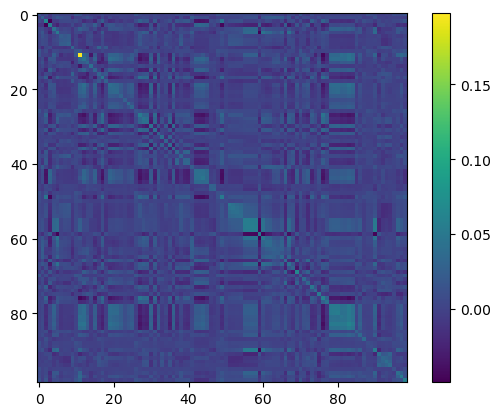

In [24]:
plt.imshow(cov_matrix.values)
plt.colorbar();

While this looks cool, it's more of less useless as a tool for doing any sort of exploration because the covariances between variables are highly [influenced by the scale of the original variable](https://en.wikipedia.org/wiki/Covariance_and_correlation#:~:text=Notably%2C%20correlation%20is%20dimensionless%20while%20covariance%20is%20in%20units%20obtained%20by%20multiplying%20the%20units%20of%20the%20two%20variables.). This will be much more useful if we convert it into a **correlation matrix**, $R$, wherein the measures of association, $\rho_{i,j}$ are all normalized, $\rho_{i,j} \in [-1, 1]$. This in effect adjusts our measures for scale and allows us to actually see which variables are the most associated.  

You can continue onto that blog post here!

## The Correlation Matrix

While this looks cool, it's more of less useless as a tool for doing any sort of exploration because the covariances between variables are highly [influenced by the scale of the original variable](https://en.wikipedia.org/wiki/Covariance_and_correlation#:~:text=Notably%2C%20correlation%20is%20dimensionless%20while%20covariance%20is%20in%20units%20obtained%20by%20multiplying%20the%20units%20of%20the%20two%20variables.). This will be much more useful if we convert it into a **correlation matrix**, $R$, wherein the measures of association, $\rho_{i,j}$ are all normalized, $\rho_{i,j} \in [-1, 1]$. This in effect adjusts our measures for scale and allows us to actually see which variables are the most associated.  

To construct a matrix formulation of correlation, we will start with a univariate formula:  

$$
\begin{align*}
\rho_{x,y} &= \frac{c(x,y)}{\sqrt{c(x,x)}\sqrt{c(y,y)}} \\
 &= \frac{(n-1)^{-1} \sum_{i=1} ^n (x_i - \bar{x})(y_i - \bar{y})}{\left(\sqrt{(n-1)^{-1} \sum_{i=1} ^n (x_i - \bar{x})(x_i - \bar{x})}\right) \left(\sqrt{(n-1)^{-1} \sum_{i=1} ^n (y_i - \bar{y})(y_i - \bar{y})}\right) } \\
&= \frac{(n-1)^{-1} \sum_{i=1} ^n (x_i - \bar{x})(y_i - \bar{y})}{(n-1)^{-1} \left(\sqrt{\sum_{i=1} ^n (x_i - \bar{x})(x_i - \bar{x})}\right) \left(\sqrt{\sum_{i=1} ^n (y_i - \bar{y})(y_i - \bar{y})}\right) } \\
&= \frac{\sum_{i=1} ^n (x_i - \bar{x})(y_i - \bar{y})}{ \sqrt{\sum_{i=1} ^n (x_i - \bar{x})(x_i - \bar{x})} \sqrt{\sum_{i=1} ^n (y_i - \bar{y})(y_i - \bar{y})} }
\end{align*}
$$

To convert a covariance matrix into a correlation matrix, we take the covariance matrix $C$:
$$
C = X^\intercal X \frac{1}{n-1}
$$

In [25]:
C = (A.T @ A ) / (len(A )-1)
C

,population,householdsize
population,0.00657,-0.00201
householdsize,-0.00201,0.05293


and we first calculate its diagonals, which are the variances of each column vector/feature. We convert these variances $\sigma^2$ into standard deviation, $\sqrt{\sigma^2}$, and take the reciprocal, $\frac{1}{\sqrt{\sigma^2}}$, as follows to obtain the diagonal matrix $S$:
$$
S = (\text{diag}(C))^{-\frac{1}{2}}
$$  

wherein each diagonal element is $\frac{1}{\sigma_{j, (j+1)}}$.

In [248]:
print("C:\n", C.values)
print()
print("diag(C):\n", np.diag(np.diag(C)))
print()
print("diag(C)^(-.5):\n", np.diag(np.diag(C)**(-.5)))

S = np.diag(np.diag(C)**(-.5))

C:
 [[ 0.00657 -0.00201]
 [-0.00201  0.05293]]

diag(C):
 [[0.00657 0.     ]
 [0.      0.05293]]

diag(C)^(-.5):
 [[12.33722017  0.        ]
 [ 0.          4.34659377]]


With that in hand, we can compute the correlation matrix $R$:
$$
R = SCS
$$

In [249]:
S @ C @ S

,0,1
0,1.000000,-0.107786
1,-0.107786,1.000000


We double check this with the `pandas` implementation of `corr()`

In [250]:
X.corr()

,population,householdsize
population,1.000000,-0.107786
householdsize,-0.107786,1.000000


We'll now return to our full dataset and compute the correlation matrix

In [251]:
S_large = np.diag(np.diag(cov_matrix)**(-.5))
corr_matrix = S_large @ cov_matrix @ S_large
corr_matrix.iloc[:5, :5]

,0,1,2,3,4
0,1.000000,-0.046148,0.231178,-0.300845,0.181603
1,-0.046148,1.000000,-0.067109,-0.235907,0.201996
2,0.231178,-0.067109,1.000000,-0.794389,-0.106738
3,-0.300845,-0.235907,-0.794389,1.000000,-0.270266
4,0.181603,0.201996,-0.106738,-0.270266,1.000000


When we visualize this matrix, we gain richer information, because we can see, relative to all of the inter-variable relationships in the data, which are the strongest.

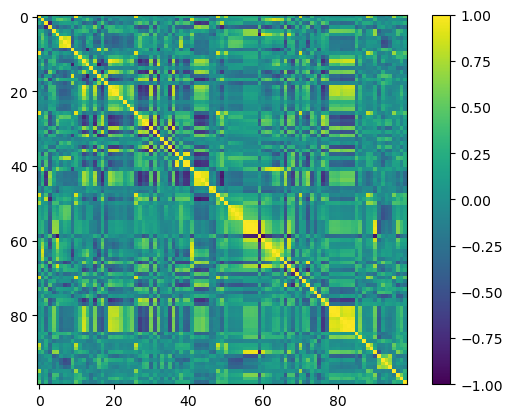

In [252]:
plt.imshow(corr_matrix.values, vmin=-1, vmax=1)
plt.colorbar();